# Produce movies of our various star terms

In [1]:
# !mamba install xmovie -y

In [2]:
import gcsfs
import xarray as xr
import numpy as np

In [3]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
from tqdm.auto import tqdm

## Making MOOOVIES

In [4]:
cmap = matplotlib.cm.RdBu_r
cmap.set_bad('0.5',1.)

def plotfunc(da, fig, tt, vmax=20):
    axarr = fig.subplots(ncols=4, nrows=2)
    # plot_terms = ['Q_star', 'Q_star_star_ocean', 'Q_star_star_atmos','Q_star_star','Q_star_res', 'Q_star_star_res']
    plot_terms = ['Q_star', 'Q_star_ocean', 'Q_star_atmos', 'Q_star_res_real','Q_star_star','Q_star_star_ocean', 'Q_star_star_atmos', 'Q_star_star_res']
    for term, ax in zip(plot_terms, axarr.flat):
        da.sel(term=term).isel(time=tt).plot(
            ax=ax,
            vmax=vmax,
            cmap=cmap,
            add_colorbar=False,
            add_labels=False
        )
        ax.text(0.05, 0.05,term, ha='left', va='bottom', transform=ax.transAxes, bbox={'color':'0.5'})

    for ax in axarr.flat:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('auto')
    fig.set_tight_layout(True)
    fig.subplots_adjust(wspace=0, hspace=0)

def write_movie(da, filename, dpi=100, framedim='time', **kwargs):
    # metadata = dict(title='Movie Test', artist='Matplotlib')
    metadata = {}
    writer = FFMpegWriter(fps=15, metadata=metadata)

    fig = plt.figure(figsize=[16,9]) # needs modification...
    
    with writer.saving(fig, filename, dpi):
        for i in tqdm(range(len(da[framedim]))):
        # for i in tqdm(range(4)): # for testing
            plotfunc(da, fig, i, **kwargs)
            writer.grab_frame()
            plt.clf()

In [5]:
fs = gcsfs.GCSFileSystem()
path = 'leap-scratch/jbusecke/scale-aware-air-sea/visualization/CM26_output_pacific_full.zarr'
path = "leap-scratch/jbusecke/scale-aware-air-sea/visualization/CM26_output_global.zarr"
path = 'leap-scratch/jbusecke/scale-aware-air-sea/visualization/CM26_output_global_v2.zarr'
mapper = fs.get_mapper(path)

In [6]:
ds_final_plot = xr.open_dataset(mapper, engine='zarr')
ds_final_plot = ds_final_plot.chunk({'time':1})
ds_final_plot = ds_final_plot.sel(term=['Q_star', 'Q_star_ocean', 'Q_star_atmos', 'Q_star_res_real','Q_star_star','Q_star_star_ocean', 'Q_star_star_atmos', 'Q_star_star_res'])
subset = 5
ds_final_plot = ds_final_plot.isel(xt_ocean=slice(0,None,subset), yt_ocean=slice(0,None, subset))
# the full thing is still too long...
ds_final_plot = ds_final_plot.isel(time=slice(0,360*3))
ds_final_plot['ql'].nbytes/1e9

13.436928

In [7]:
# %matplotlib inline
# fig = plt.figure(figsize=[16,9])
# plotfunc(ds_final_plot['ql'], fig, 0)

In [10]:
for var, vmax in [('ql', 25), ('qh', 15)]:
    dataarrays = {}
    dataarrays['daily'] = ds_final_plot[var]
    # dataarrays['weekly'] = ds_final_plot[var].coarsen(time=7, boundary='trim').mean()
    dataarrays['monthly'] = ds_final_plot[var].coarsen(time=30, boundary='trim').mean()
    # for freq in ['daily', 'monthly']:
    for freq in ['daily']:
        filename = f'movies/small_scale_terms_{var}_{freq}.mp4'
        print(f"Writing {freq} data to {filename}")
        write_movie(dataarrays[freq].chunk({'time':1}), filename, vmax=vmax)

Writing daily data to movies/small_scale_terms_ql_daily.mp4


/tmp/ipykernel_9189/2918284525.py:5: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  dataarrays['monthly'] = ds_final_plot[var].coarsen(time=30, boundary='trim').mean()


  0%|          | 0/1080 [00:00<?, ?it/s]


KeyboardInterrupt



## Using xmovie (this is cursed and accumulates memory)

# I might be able to fix that with plt.cfl()? Need to try.

In [6]:
from xmovie import Movie
mov = Movie(da, plotfunc=plotfunc, input_check=False, dpi=100)

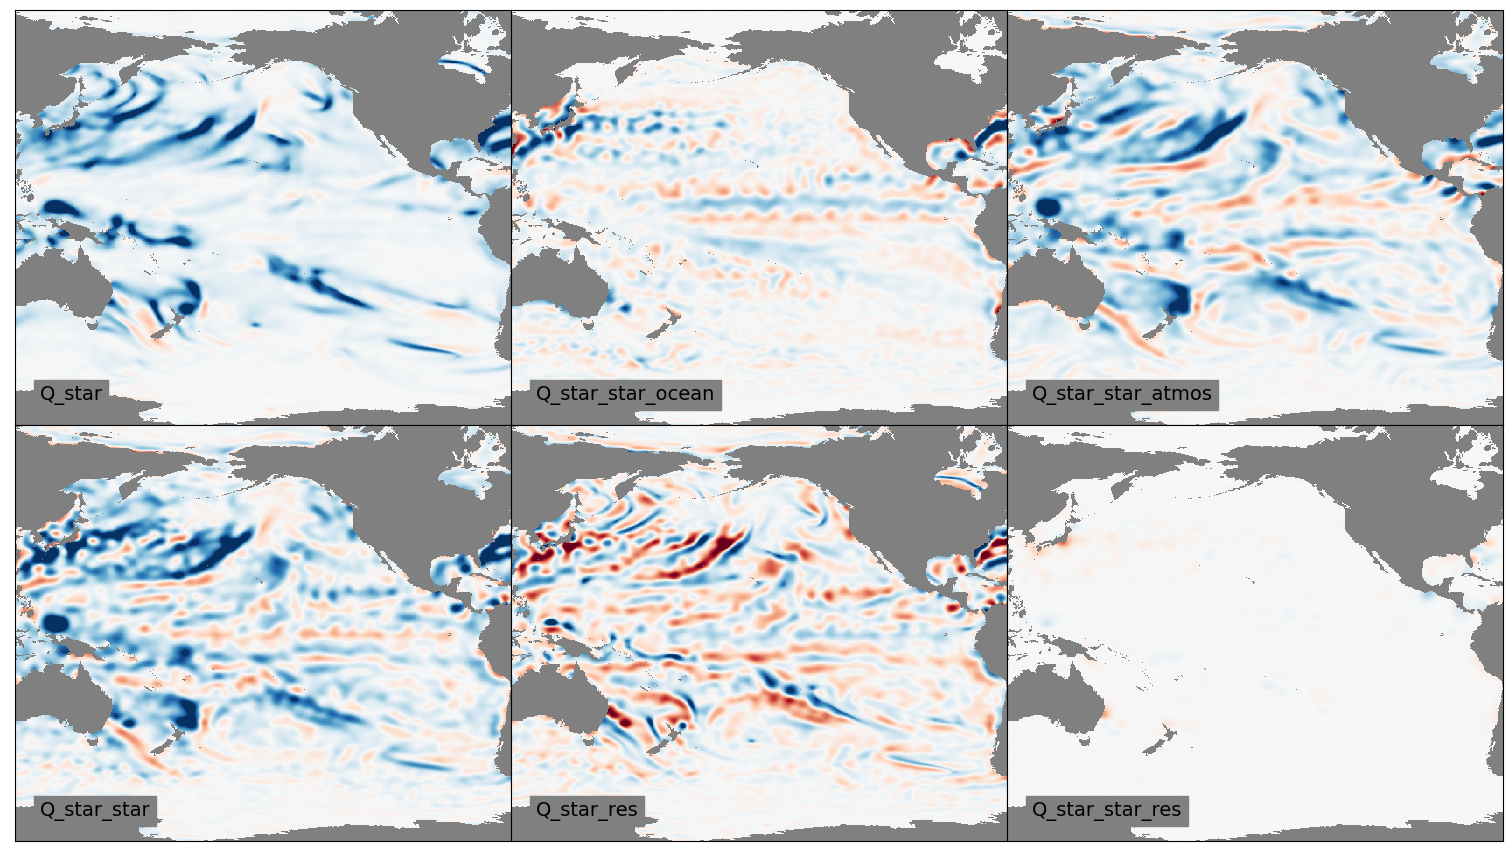

In [7]:
%matplotlib inline
mov.preview(0)

In [8]:
mov.save('star_terms_test_parallel.mp4', progress=True)

  0%|          | 0/200 [00:00<?, ?it/s]

Movie created at star_terms_test_parallel.mp4


In [12]:
import gc
gc.collect()

1783336